# Part I: Profiling expression STRs across 17 human tissues

In [1]:
# Set up
%pylab inline

# Params
BASEDATADIR = "/storage/mgymrek/gtex-estrs-paper/revision/data/"
BASERESULTSDIR = "/storage/mgymrek/gtex-estrs-paper/revision/results"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-calling"
FIGPREFIX = "Figure1"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Tissue info ##############
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

SHORTEN = {
    "Artery-Aorta":"Artery A."     ,
    "Artery-Tibial": "Artery T.",
    "Adipose-Subcutaneous": "Adipose S.",    
    "Adipose-Visceral":"Adipose V.",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "E. Mucosa",
    "Esophagus-Muscularis":"E Muscularis",
    "Heart-LeftVentricle":"Ventricle",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "Skin Unexposed",
    "Skin-SunExposed":"Skin Leg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood",
    "permuted":"Permuted",
    "LCL": "LCL"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]

############ Load data ################
NGESTR = pd.read_csv(os.path.join(DATADIR, "2016_estrs_table.csv"))

# Linear regression data
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(DATADIR, "%s_LinearRegression.tab"%t), sep="\t", usecols=["gene","str.start","p.wald"])
    # Reformat gene names and start coords
    data[t]["gene"] = data[t]["gene"].apply(lambda x: x.split(".")[0])
    data[t]["str.start"] = (data[t]["str.start"] + 1).apply(int)
data["permuted"] = pd.read_csv(os.path.join(DATADIR, "WholeBlood_LinearRegression_permuted.tab"), sep="\t")
data["LCL"] = NGESTR

master = {} # Map of tissue -> master data. Include all loci for comparisons below
"""
for t in TISSUES:
    df = pd.read_csv(os.path.join(DATADIR, "%s_MasterTable.tab"%t), sep="\t")
    df = df[~np.isnan(df["best.str.start"])]
    df["str.start"] = (df["best.str.start"] + 1).apply(int)
    df["gene"] = df["gene"].apply(lambda x: x.split(".")[0])
    df = pd.merge(df, data[t], on=["str.start","gene","beta"], how="outer")
    df["significant"] = (df["significant"]==1)
    df["signif_%s"%t] = df["significant"]
    master[t] = df
"""
master["LCL"] = NGESTR
master["LCL"]["str.id"] = master["LCL"]["str.start"].apply(lambda x: "STR_%s"%(x-1))
master["LCL"]["significant"] = master["LCL"]["signif.estr"]

Populating the interactive namespace from numpy and matplotlib


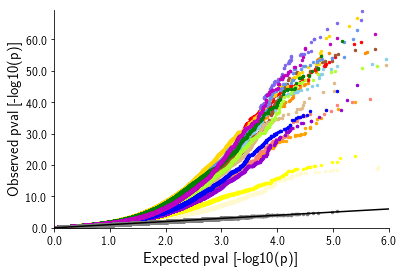

In [2]:
# Figure 1B: QQ Plot

TISSUES = sorted(TISSUES)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
maxval = 0
for t in TISSUES + ["permuted"]:
    unif = sorted(list(np.random.uniform(low=0, high=1, size=data[t].shape[0])))
    unif_log = [-1*np.log10(x) for x in unif]
    pvals = sorted(list(data[t]["p.wald"]))
    pvals_log = [-1*np.log10(x) for x in pvals]
    maxval = max([maxval]+pvals_log)
    ax.scatter(unif_log, pvals_log, color=COLORS[t], label=SHORTEN[t], s=6)
ax.plot([0,6],[0,6], color="black")
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot.png"%FIGPREFIX))

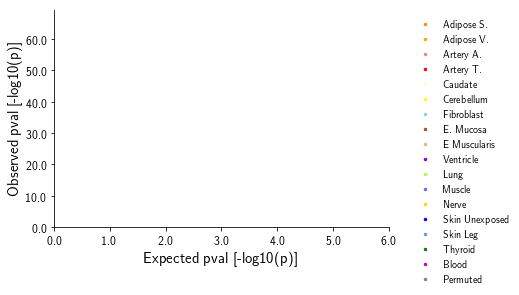

In [3]:
# Additionally plot the skeleton as pdf to use in Illustrator
fig = plt.figure()
ax = fig.add_subplot(111)
for t in TISSUES + ["permuted"]:
    ax.scatter([],[], color=COLORS[t], label=SHORTEN[t], s=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False);
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot_skeleton.pdf"%FIGPREFIX))